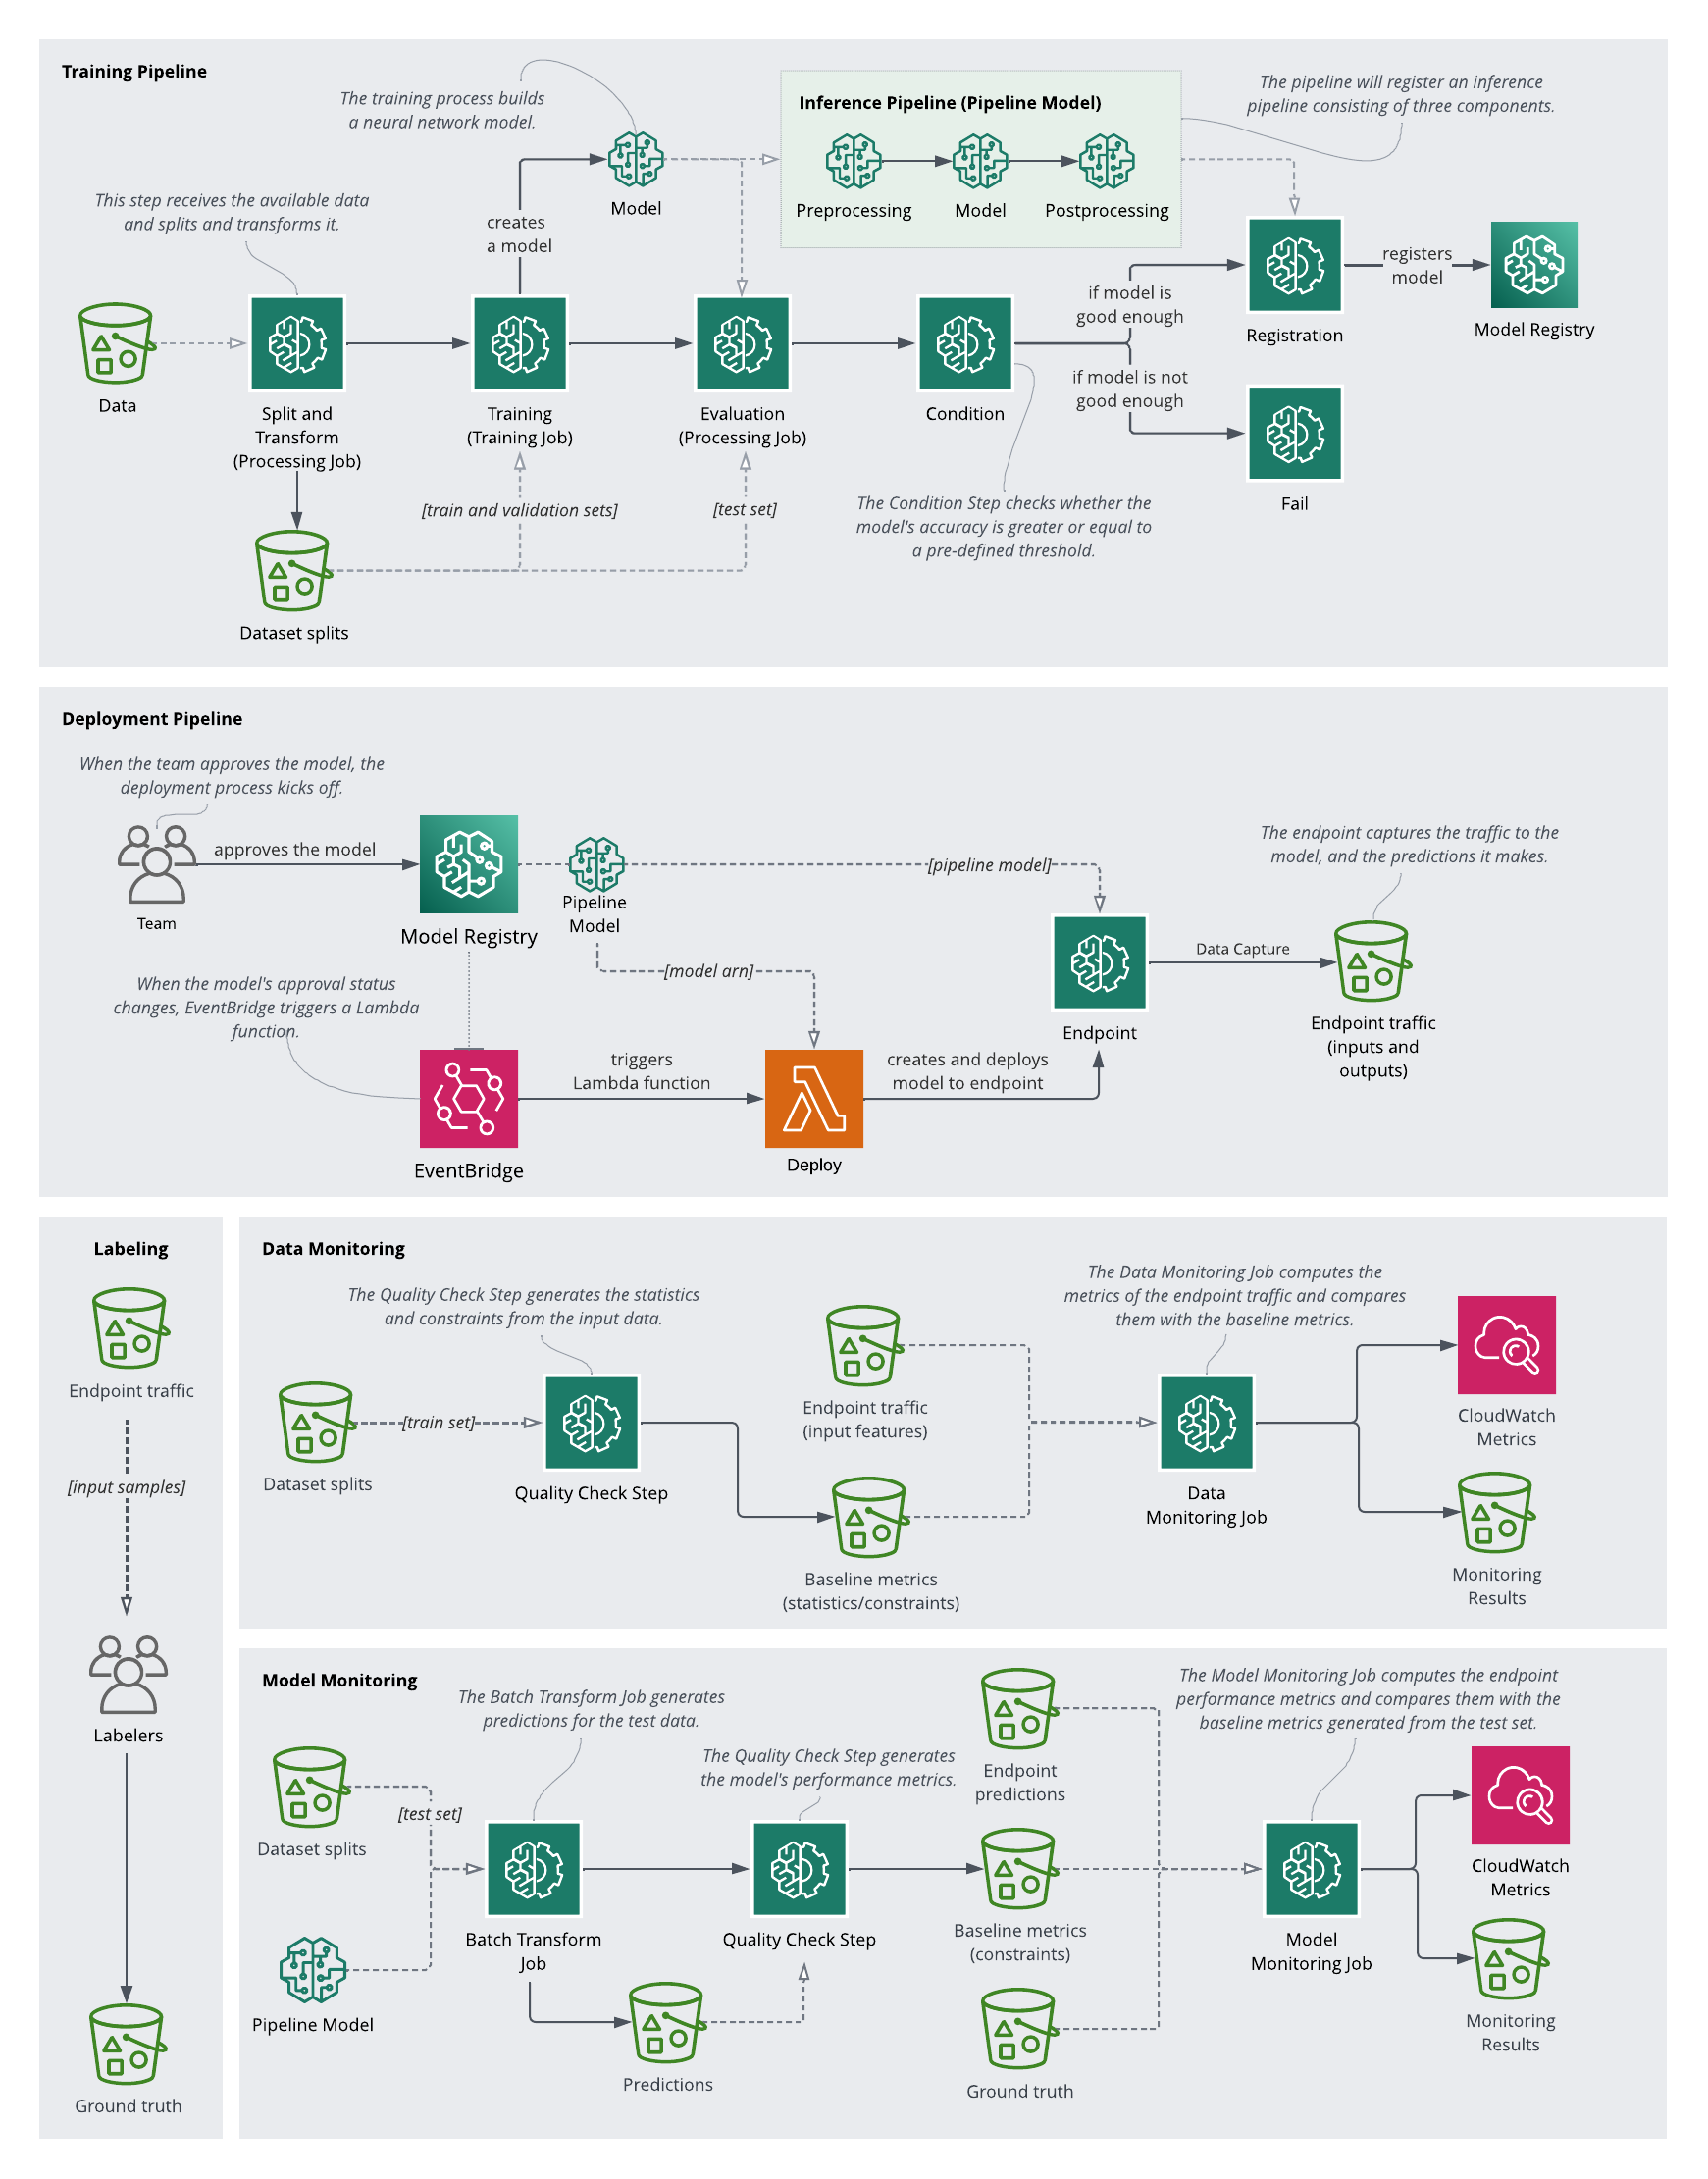

 The Architecture basically consists of 4 pipeline -  A training pipeline, an inference pipeline, a deployment pipeline, and a monitoring pipeline.

Above is an architectural diagram showing how the system is structured:

Lets set up the environment and prepare to run the notebook.

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv

import os
import json
import logging
import sys
from pathlib import Path

import ipytest

CODE_FOLDER = Path("code")

if not os.path.exists(CODE_FOLDER):
    os.makedirs(CODE_FOLDER)
    
sys.path.extend([f"./{CODE_FOLDER}"])

DATA_FILEPATH = "penguins.csv"

ipytest.autoconfig(raise_on_error=True)

# By default, The SageMaker SDK logs events related to the default
# configuration using the INFO level. To prevent these from spoiling
# the output of this notebook cells, we can change the logging
# level to ERROR instead.
logging.getLogger("sagemaker.config").setLevel(logging.ERROR)

We can run this notebook in Local Mode to test some of the system components in local environment. Unfortunately, not every component is supported in Local Mode.

Setting the LOCAL_MODE variable to True will run every supported pipeline component locally. Setting the variable to False will run the pipeline in SageMaker.

In [10]:
LOCAL_MODE = True

Loading the environment variables we need to run the notebook.

In [11]:
import os

bucket = os.environ["BUCKET"]
role = os.environ["ROLE"]

COMET_API_KEY = os.environ.get("COMET_API_KEY", None)
COMET_PROJECT_NAME = os.environ.get("COMET_PROJECT_NAME", None)

In [15]:
# We can retrieve the architecture of the local
# computer using the `uname -m` command.
architecture = !(uname -m)

IS_ARM64_ARCHITECTURE = architecture[0] == "arm64"

Let's create a configuration dictionary with different settings depending on whether we are running the pipeline in Local Mode. We'll use this dictionary to configure the pipeline components.

In [13]:
import sagemaker
from sagemaker.workflow.pipeline_context import LocalPipelineSession, PipelineSession

pipeline_session = PipelineSession(default_bucket=bucket) if not LOCAL_MODE else None

if LOCAL_MODE:
    config = {
        "session": LocalPipelineSession(default_bucket=bucket),
        "instance_type": "local",
        # We need to use a custom Docker image when we run the pipeline
        # in Local Model on an ARM64 machine.
        "image": (
            "sagemaker-tensorflow-toolkit-local" if IS_ARM64_ARCHITECTURE else None
        ),
    }
else:
    config = {
        "session": pipeline_session,
        "instance_type": "ml.m5.xlarge",
        "image": None,
    }

# These specific settings refer to the SageMaker
# TensorFlow container we'll use.
config["framework_version"] = "2.12"
config["py_version"] = "py310"

Windows Support for Local Mode is Experimental


In [14]:
import boto3

S3_LOCATION = f"s3://{bucket}/penguins"

sagemaker_session = sagemaker.session.Session()
sagemaker_client = boto3.client("sagemaker")
iam_client = boto3.client("iam")
region = boto3.Session().region_name

IAM - https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/iam.html

sagemaker - https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html

# Exploratory Data Analysis

In [16]:
import numpy as np
import pandas as pd

penguins = pd.read_csv(DATA_FILEPATH)
penguins.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


We can see the dataset contains the following columns:

species: The species of a penguin. This is the column we want to predict.

island: The island where the penguin was found

culmen_length_mm: The length of the penguin's culmen (bill) in millimeters

culmen_depth_mm: The depth of the penguin's culmen in millimeters

flipper_length_mm: The length of the penguin's flipper in millimeters

body_mass_g: The body mass of the penguin in grams

sex: The sex of the penguin

In [17]:
penguins.describe(include="all")

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
count,344,344,342.000000,342.000000,342.000000,342.000000,334
unique,3,3,NaN,NaN,NaN,NaN,3
top,Adelie,Biscoe,NaN,NaN,NaN,NaN,MALE
freq,152,168,NaN,NaN,NaN,NaN,168
mean,NaN,NaN,43.921930,17.151170,200.915205,4201.754386,NaN
std,NaN,NaN,5.459584,1.974793,14.061714,801.954536,NaN
min,NaN,NaN,32.100000,13.100000,172.000000,2700.000000,NaN
25%,NaN,NaN,39.225000,15.600000,190.000000,3550.000000,NaN
50%,NaN,NaN,44.450000,17.300000,197.000000,4050.000000,NaN
75%,NaN,NaN,48.500000,18.700000,213.000000,4750.000000,NaN


In [18]:
species_distribution = penguins["species"].value_counts()
island_distribution = penguins["island"].value_counts()
sex_distribution = penguins["sex"].value_counts()

print(species_distribution, end="\n\n")
print(island_distribution, end="\n\n")
print(sex_distribution)

species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64

island
Biscoe       168
Dream        124
Torgersen     52
Name: count, dtype: int64

sex
MALE      168
FEMALE    165
.           1
Name: count, dtype: int64


The distribution of the categories in our data are:

1. species: There are 3 species of penguins in the dataset: Adelie (152), Gentoo (124), and Chinstrap (68).
2. island: Penguins are from 3 islands: Biscoe (168), Dream (124), and Torgersen (52).
3. sex: We have 168 male penguins, 165 female penguins, and 1 penguin with an ambiguous gender (.).

Let's replace the ambiguous value in the sex column with a null value:

In [19]:
penguins["sex"] = penguins["sex"].replace(".", np.nan)

# Let's display the new distribution of the column:
sex_distribution = penguins["sex"].value_counts()
sex_distribution

sex
MALE      168
FEMALE    165
Name: count, dtype: int64

In [20]:
penguins.isna().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

Let get rid of the missing values.

In [21]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="most_frequent")
penguins.iloc[:, :] = imputer.fit_transform(penguins)

# Let's display again the number of missing values:
penguins.isna().sum()

species              0
island               0
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

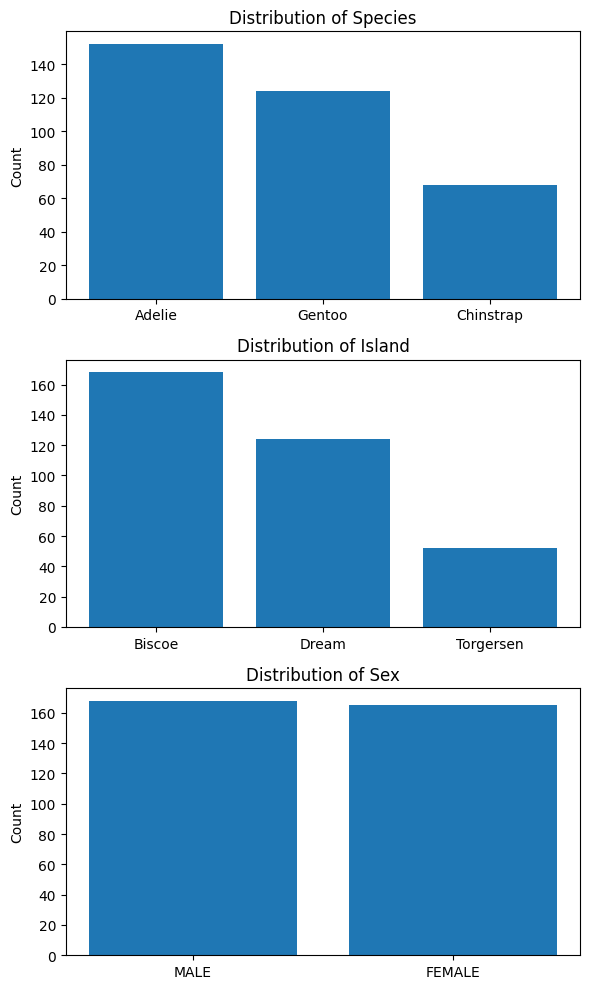

In [22]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(6, 10))

axs[0].bar(species_distribution.index, species_distribution.values)
axs[0].set_ylabel("Count")
axs[0].set_title("Distribution of Species")

axs[1].bar(island_distribution.index, island_distribution.values)
axs[1].set_ylabel("Count")
axs[1].set_title("Distribution of Island")

axs[2].bar(sex_distribution.index, sex_distribution.values)
axs[2].set_ylabel("Count")
axs[2].set_title("Distribution of Sex")

plt.tight_layout()
plt.show()

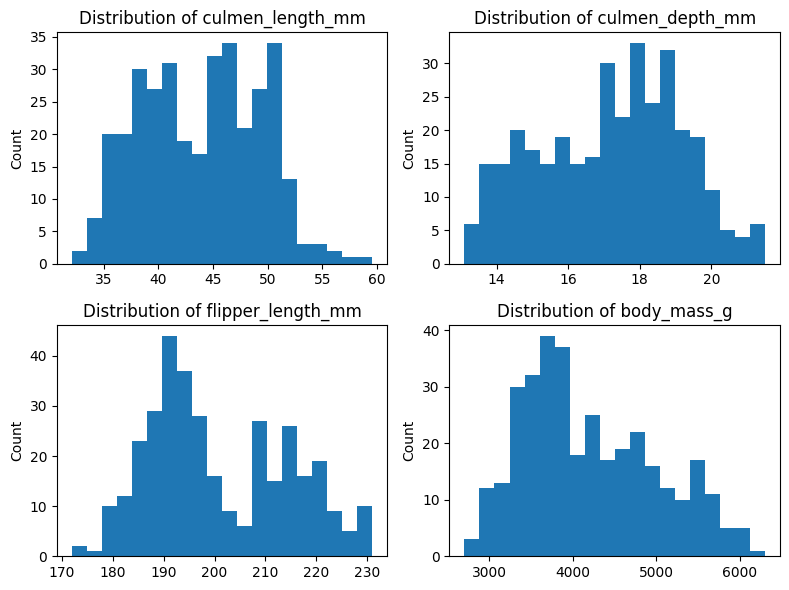

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

axs[0, 0].hist(penguins["culmen_length_mm"], bins=20)
axs[0, 0].set_ylabel("Count")
axs[0, 0].set_title("Distribution of culmen_length_mm")

axs[0, 1].hist(penguins["culmen_depth_mm"], bins=20)
axs[0, 1].set_ylabel("Count")
axs[0, 1].set_title("Distribution of culmen_depth_mm")

axs[1, 0].hist(penguins["flipper_length_mm"], bins=20)
axs[1, 0].set_ylabel("Count")
axs[1, 0].set_title("Distribution of flipper_length_mm")

axs[1, 1].hist(penguins["body_mass_g"], bins=20)
axs[1, 1].set_ylabel("Count")
axs[1, 1].set_title("Distribution of body_mass_g")

plt.tight_layout()
plt.show()

In [24]:
penguins.cov(numeric_only=True)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
culmen_length_mm,29.679415,-2.516984,50.260588,2596.971151
culmen_depth_mm,-2.516984,3.877201,-16.108849,-742.660180
flipper_length_mm,50.260588,-16.108849,197.269501,9792.552037
body_mass_g,2596.971151,-742.660180,9792.552037,640316.716388


Here are three examples of what we get from interpreting the covariance matrix below:

1. The positive covariance of 50.26 between culmen length and flippler length suggests that larger values of culmen length are associated with larger values of flipper length. As one increases, generally so does the other.
2. The positive covariance of 2596.97 between culmen length and body mass suggests that heavier penguins generally have longer culmens. There is a tendency for these two variables to increase together.
3. The negative covariance of -742.66 between culmen depth and body mass suggests a general tendency that penguins with deeper culmens weigh less.

Let's now display the correlation matrix. "Correlation" measures both the strength and direction of the linear relationship between two variables:

In [25]:
penguins.corr(numeric_only=True)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
culmen_length_mm,1.000000,-0.234635,0.656856,0.595720
culmen_depth_mm,-0.234635,1.000000,-0.582472,-0.471339
flipper_length_mm,0.656856,-0.582472,1.000000,0.871302
body_mass_g,0.595720,-0.471339,0.871302,1.000000


Here are three examples of what we get from interpreting the correlation matrix below:

1. Penguins that weight more tend to have longer flippers.
2. Penguins with a shallower culmen tend to have longer flippers.
3. Penguins with longer culmens tend to have longer flippers.

Let's display the distribution of species by island:

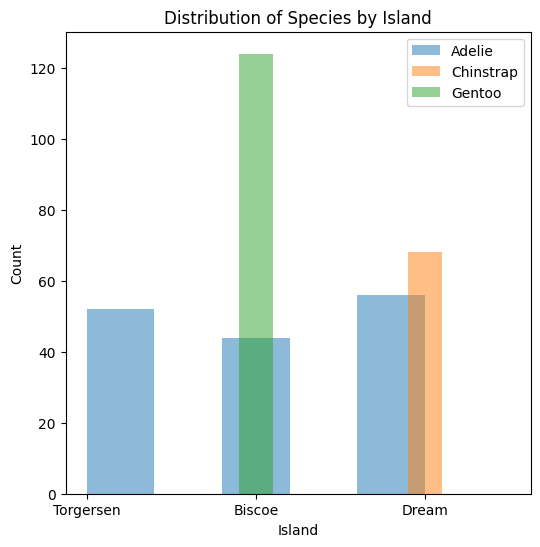

In [26]:
unique_species = penguins["species"].unique()

fig, ax = plt.subplots(figsize=(6, 6))
for species in unique_species:
    data = penguins[penguins["species"] == species]
    ax.hist(data["island"], bins=5, alpha=0.5, label=species)

ax.set_xlabel("Island")
ax.set_ylabel("Count")
ax.set_title("Distribution of Species by Island")
ax.legend()
plt.show()


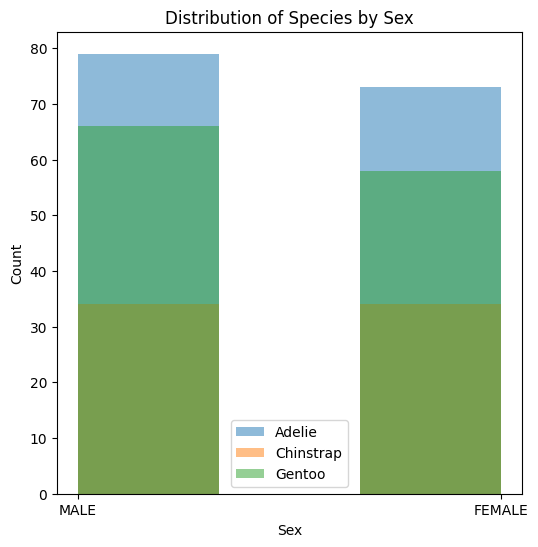

In [27]:
fig, ax = plt.subplots(figsize=(6, 6))

for species in unique_species:
    data = penguins[penguins["species"] == species]
    ax.hist(data["sex"], bins=3, alpha=0.5, label=species)

ax.set_xlabel("Sex")
ax.set_ylabel("Count")
ax.set_title("Distribution of Species by Sex")

ax.legend()
plt.show()

# Splitting and Transforming the Data

The first step we need in the pipeline is a Processing Step to run a script that will split and transform the data.

This Processing Step will create a SageMaker Processing Job in the background, run the script, and upload the output to S3. You can use Processing Jobs to perform data preprocessing, post-processing, feature engineering, data validation, and model evaluation. Check the ProcessingStep SageMaker's SDK documentation for more information.

We will store the script in a folder called processing and add it to the system path so we can later import it as a module.

Important Links - 

Processing step - https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.ProcessingStep

 ProcessingStep SageMaker's SDK documentation - https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html#step-type-processing

In [3]:
(CODE_FOLDER / "processing").mkdir(parents=True, exist_ok=True)
sys.path.extend([f"./{CODE_FOLDER}/processing"])

In [4]:
%%writefile {CODE_FOLDER}/processing/script.py
# | filename: script.py
# | code-line-numbers: true

import os
import tarfile
import tempfile
from pathlib import Path

import joblib
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler


def preprocess(base_directory):
    """Load the supplied data, split it and transform it."""
    df = _read_data_from_input_csv_files(base_directory)

    target_transformer = ColumnTransformer(
        transformers=[("species", OrdinalEncoder(), [0])],
    )

    numeric_transformer = make_pipeline(
        SimpleImputer(strategy="mean"),
        StandardScaler(),
    )

    categorical_transformer = make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OneHotEncoder(),
    )

    features_transformer = ColumnTransformer(
        transformers=[
            (
                "numeric",
                numeric_transformer,
                make_column_selector(dtype_exclude="object"),
            ),
            ("categorical", categorical_transformer, ["island"]),
        ],
    )

    df_train, df_validation, df_test = _split_data(df)

    _save_train_baseline(base_directory, df_train)
    _save_test_baseline(base_directory, df_test)

    y_train = target_transformer.fit_transform(
        np.array(df_train.species.values).reshape(-1, 1),
    )
    y_validation = target_transformer.transform(
        np.array(df_validation.species.values).reshape(-1, 1),
    )
    y_test = target_transformer.transform(
        np.array(df_test.species.values).reshape(-1, 1),
    )

    df_train = df_train.drop("species", axis=1)
    df_validation = df_validation.drop("species", axis=1)
    df_test = df_test.drop("species", axis=1)

    X_train = features_transformer.fit_transform(df_train)  # noqa: N806
    X_validation = features_transformer.transform(df_validation)  # noqa: N806
    X_test = features_transformer.transform(df_test)  # noqa: N806

    _save_splits(
        base_directory,
        X_train,
        y_train,
        X_validation,
        y_validation,
        X_test,
        y_test,
    )
    _save_model(base_directory, target_transformer, features_transformer)


def _read_data_from_input_csv_files(base_directory):
    """Read the data from the input CSV files.

    This function reads every CSV file available and
    concatenates them into a single dataframe.
    """
    input_directory = Path(base_directory) / "input"
    files = list(input_directory.glob("*.csv"))

    if len(files) == 0:
        message = f"The are no CSV files in {input_directory.as_posix()}/"
        raise ValueError(message)

    raw_data = [pd.read_csv(file) for file in files]
    df = pd.concat(raw_data)

    # Shuffle the data
    return df.sample(frac=1, random_state=42)


def _split_data(df):
    """Split the data into train, validation, and test."""
    df_train, temp = train_test_split(df, test_size=0.3)
    df_validation, df_test = train_test_split(temp, test_size=0.5)

    return df_train, df_validation, df_test


def _save_train_baseline(base_directory, df_train):
    """Save the untransformed training data to disk.

    We will need the training data to compute a baseline to
    determine the quality of the data that the model receives
    when deployed.
    """
    baseline_path = Path(base_directory) / "train-baseline"
    baseline_path.mkdir(parents=True, exist_ok=True)

    df = df_train.copy().dropna()

    # To compute the data quality baseline, we don't need the
    # target variable, so we'll drop it from the dataframe.
    df = df.drop("species", axis=1)

    df.to_csv(baseline_path / "train-baseline.csv", header=True, index=False)


def _save_test_baseline(base_directory, df_test):
    """Save the untransformed test data to disk.

    We will need the test data to compute a baseline to
    determine the quality of the model predictions when deployed.
    """
    baseline_path = Path(base_directory) / "test-baseline"
    baseline_path.mkdir(parents=True, exist_ok=True)

    df = df_test.copy().dropna()

    # We'll use the test baseline to generate predictions later,
    # and we can't have a header line because the model won't be
    # able to make a prediction for it.
    df.to_csv(baseline_path / "test-baseline.csv", header=False, index=False)


def _save_splits(
    base_directory,
    X_train,  # noqa: N803
    y_train,
    X_validation,  # noqa: N803
    y_validation,
    X_test,  # noqa: N803
    y_test,
):
    """Save data splits to disk.

    This function concatenates the transformed features
    and the target variable, and saves each one of the split
    sets to disk.
    """
    train = np.concatenate((X_train, y_train), axis=1)
    validation = np.concatenate((X_validation, y_validation), axis=1)
    test = np.concatenate((X_test, y_test), axis=1)

    train_path = Path(base_directory) / "train"
    validation_path = Path(base_directory) / "validation"
    test_path = Path(base_directory) / "test"

    train_path.mkdir(parents=True, exist_ok=True)
    validation_path.mkdir(parents=True, exist_ok=True)
    test_path.mkdir(parents=True, exist_ok=True)

    pd.DataFrame(train).to_csv(train_path / "train.csv", header=False, index=False)
    pd.DataFrame(validation).to_csv(
        validation_path / "validation.csv",
        header=False,
        index=False,
    )
    pd.DataFrame(test).to_csv(test_path / "test.csv", header=False, index=False)


def _save_model(base_directory, target_transformer, features_transformer):
    """Save the Scikit-Learn transformation pipelines.

    This function creates a model.tar.gz file that
    contains the two transformation pipelines we built
    to transform the data.
    """
    with tempfile.TemporaryDirectory() as directory:
        joblib.dump(target_transformer, Path(directory) / "target.joblib")
        joblib.dump(features_transformer, Path(directory) / "features.joblib")

        model_path = Path(base_directory) / "model"
        model_path.mkdir(parents=True, exist_ok=True)

        with tarfile.open(f"{(model_path / 'model.tar.gz').as_posix()}", "w:gz") as tar:
            tar.add(Path(directory) / "target.joblib", arcname="target.joblib")
            tar.add(
                Path(directory) / "features.joblib", arcname="features.joblib",
            )


if __name__ == "__main__":
    preprocess(base_directory="/opt/ml/processing")

Writing code/processing/script.py


# Step 2 - Caching Configuration

Several SageMaker Pipeline steps support caching. When a step runs, and dependending on the configured caching policy, SageMaker will try to reuse the result of a previous successful run of the same step. You can find more information about this topic in Caching Pipeline Steps.

Link to caching document - https://docs.aws.amazon.com/sagemaker/latest/dg/pipelines-caching.html

Let's define a caching policy that we'll reuse on every step:

In [5]:
from sagemaker.workflow.steps import CacheConfig

cache_config = CacheConfig(enable_caching=True, expire_after="15d")

# Step 3 - Pipeline Configuration

We can parameterize a SageMaker Pipeline to make it more flexible. In this case, we'll use a parameter to pass the location of the dataset we want to process. We can execute the pipeline with different datasets by changing the value of this parameter. Check Pipeline Parameters for more information.


Link - https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-parameters.html

In [ ]:
from sagemaker.workflow.parameters import ParameterString
from sagemaker.workflow.pipeline_definition_config import PipelineDefinitionConfig

pipeline_definition_config = PipelineDefinitionConfig(use_custom_job_prefix=True)

dataset_location = ParameterString(
    name="dataset_location",
    default_value=f"{S3_LOCATION}/data",
)

# Step 4 - Setting up the Processing Step

Let's now define the ProcessingStep that we'll use in the pipeline to run the script that will split and transform the data.

A processor gives the Processing Step information about the hardware and software that SageMaker should use to launch a Processing Job. To run the script we created, we need access to Scikit-Learn, so we can use the SKLearnProcessor processor that comes out-of-the-box with the SageMaker's Python SDK.

SageMaker manages the infrastructure of a Processing Job. It provisions resources for the duration of the job, and cleans up when it completes. The Processing Container image that SageMaker uses to run a Processing Job can either be a SageMaker built-in image or a custom image:

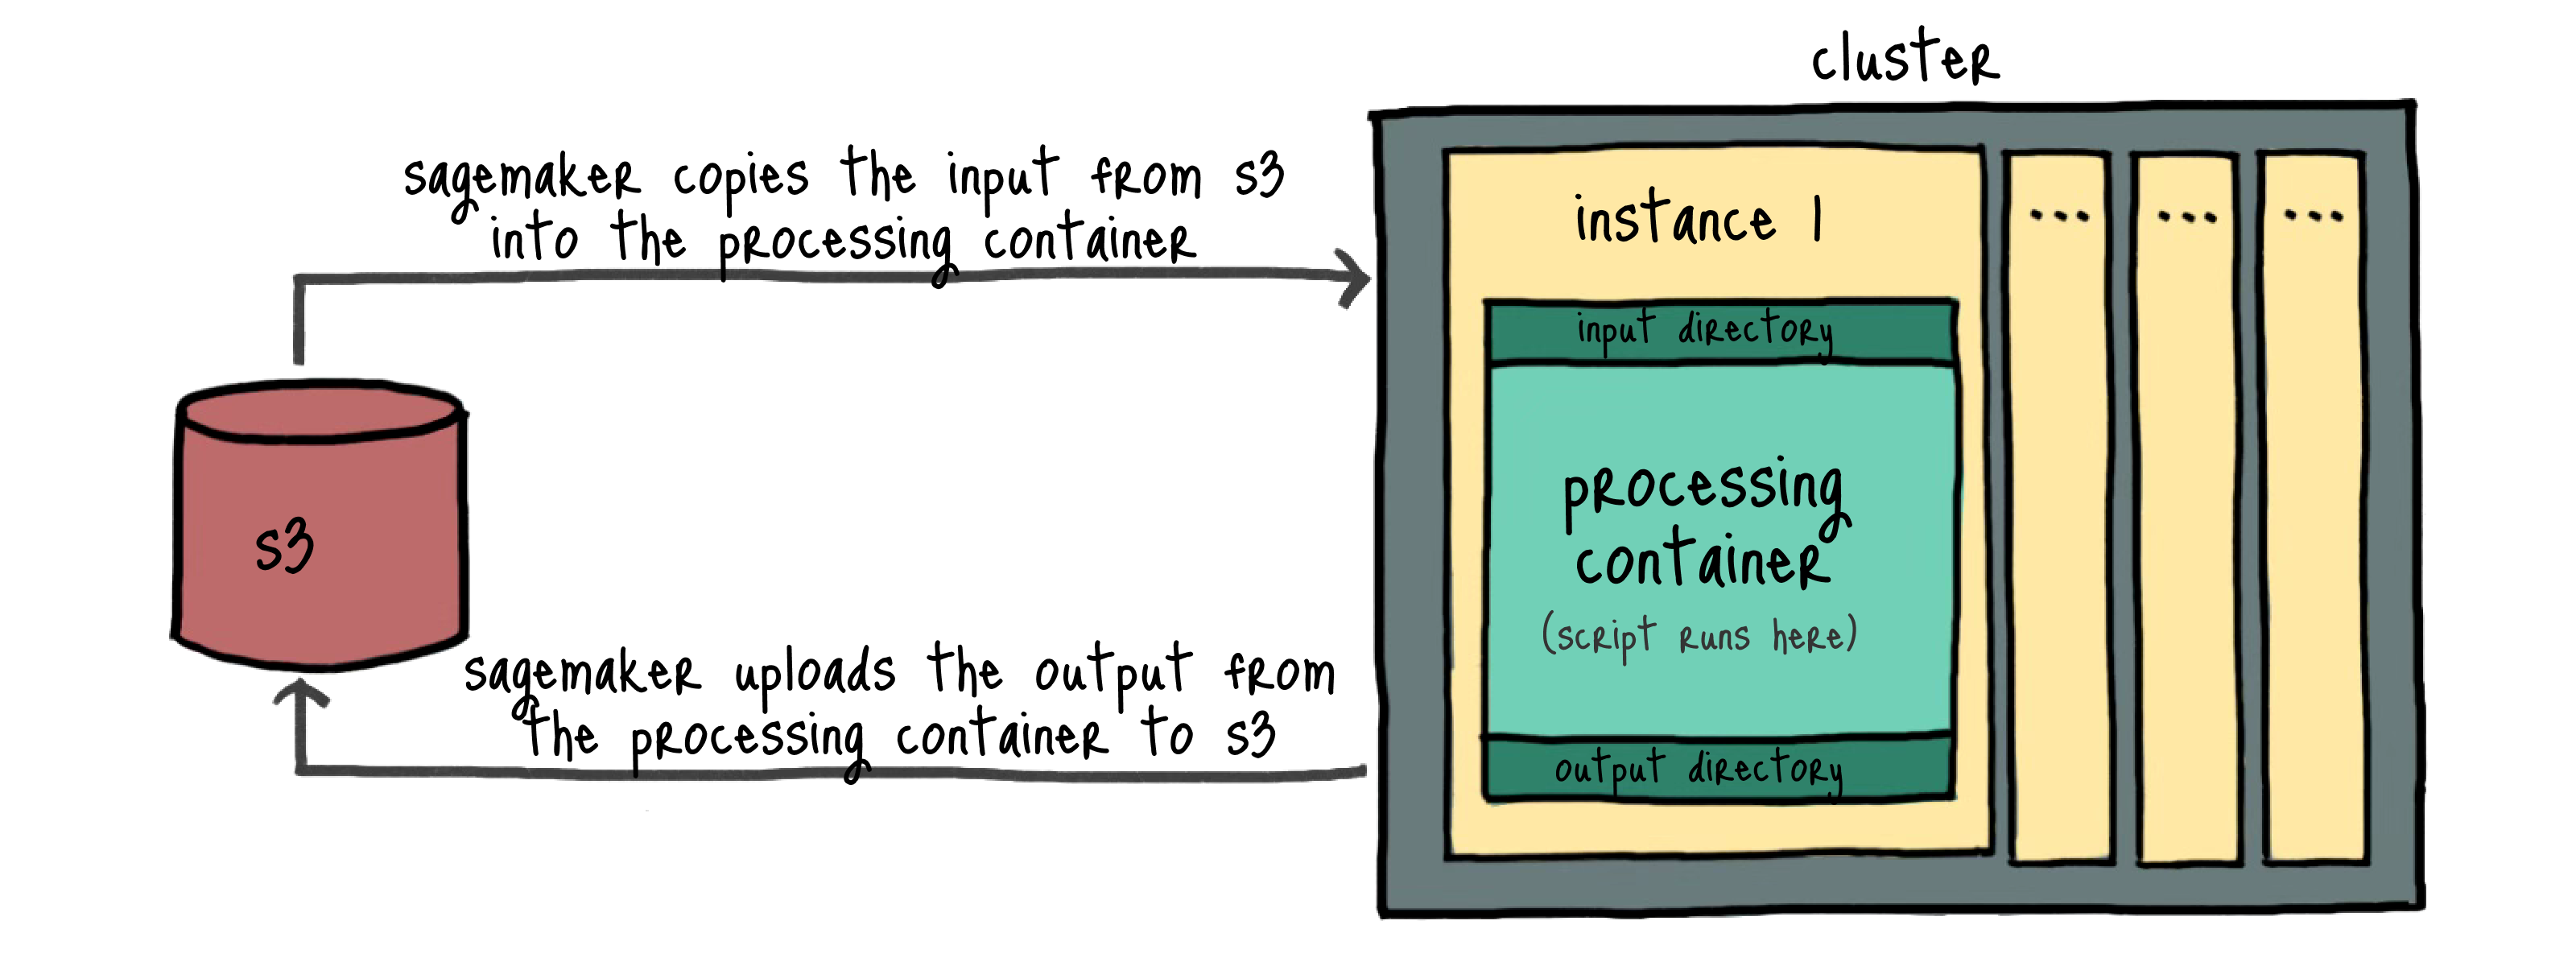

The Data Processing with Framework Processors page discusses other built-in processors you can use. The Docker Registry Paths and Example Code page contains information about the available framework versions for each region.

Data Processing with Framework Processors - https://docs.aws.amazon.com/sagemaker/latest/dg/processing-job-frameworks.html

In [ ]:
from sagemaker.sklearn.processing import SKLearnProcessor

processor = SKLearnProcessor(
    base_job_name="preprocess-data",
    framework_version="1.2-1",
    # By default, a new account doesn't have access to `ml.m5.xlarge` instances.
    # If you haven't requested a quota increase yet, you can use an
    # `ml.t3.medium` instance type instead. This will work out of the box, but
    # the Processing Job will take significantly longer than it should have.
    # To get access to `ml.m5.xlarge` instances, you can request a quota
    # increase under the Service Quotas section in your AWS account.
    instance_type=config["instance_type"],
    instance_count=1,
    role=role,
    sagemaker_session=config["session"],
)

Let's now define the Processing Step that we'll use in the pipeline.

This step will specify the list of inputs that we'll access from the preprocessing script. In this case, the input is the dataset we stored in S3. We also have a few outputs that we want SageMaker to capture when the Processing Job finishes.

In [ ]:
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.workflow.steps import ProcessingStep

preprocessing_step = ProcessingStep(
    name="preprocess-data",
    step_args=processor.run(
        code=f"{(CODE_FOLDER / 'processing' / 'script.py').as_posix()}",
        inputs=[
            ProcessingInput(
                source=dataset_location,
                destination="/opt/ml/processing/input",
            ),
        ],
        outputs=[
            ProcessingOutput(
                output_name="train",
                source="/opt/ml/processing/train",
                destination=f"{S3_LOCATION}/preprocessing/train",
            ),
            ProcessingOutput(
                output_name="validation",
                source="/opt/ml/processing/validation",
                destination=f"{S3_LOCATION}/preprocessing/validation",
            ),
            ProcessingOutput(
                output_name="test",
                source="/opt/ml/processing/test",
                destination=f"{S3_LOCATION}/preprocessing/test",
            ),
            ProcessingOutput(
                output_name="model",
                source="/opt/ml/processing/model",
                destination=f"{S3_LOCATION}/preprocessing/model",
            ),
            ProcessingOutput(
                output_name="train-baseline",
                source="/opt/ml/processing/train-baseline",
                destination=f"{S3_LOCATION}/preprocessing/train-baseline",
            ),
            ProcessingOutput(
                output_name="test-baseline",
                source="/opt/ml/processing/test-baseline",
                destination=f"{S3_LOCATION}/preprocessing/test-baseline",
            ),
        ],
    ),
    cache_config=cache_config,
)

# Step 5 - Creating the Pipeline

We can now create the SageMaker Pipeline and submit its definition to the SageMaker Pipelines service to create the pipeline if it doesn't exist or update it if it does.

In [ ]:
from sagemaker.workflow.pipeline import Pipeline

session3_pipeline = Pipeline(
    name="session3-pipeline",
    parameters=[dataset_location],
    steps=[
        preprocessing_step,
    ],
    pipeline_definition_config=pipeline_definition_config,
    sagemaker_session=config["session"],
)

session3_pipeline.upsert(role_arn=role)

#  Training the Model